In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-15 16:24:38.653275: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)
ds_path = "/drive0-storage/Gracia/Dataset/dataset_1"

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(ds_path,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(ds_path,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      seed = 123,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-15 16:24:40.824016: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 16:24:41.483762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38215 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:0f:00.0, compute capability: 8.0


Found 21408 files belonging to 3 classes.
Using 17127 files for training.
Found 21408 files belonging to 3 classes.
Using 4281 files for validation.


In [4]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 242.6295
(184, 216, 3)


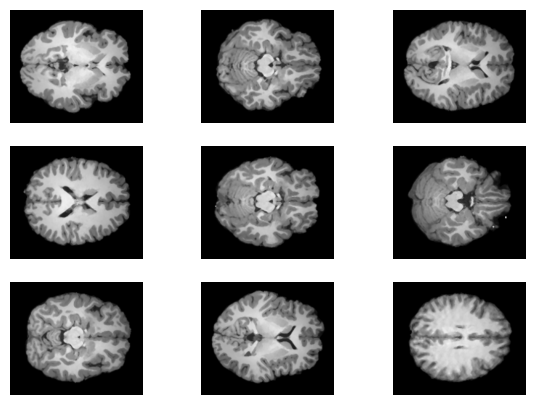

In [6]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [7]:
with tf.device("CPU"):
    AUTOTUNE = tf.data.AUTOTUNE
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    # Buffered prefetching
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [8]:
for images in train_ds.take(1):
    img = images[0]
    print(img.shape)  
    print(img.dtype)  
    print(np.min(img),np.max(img))  

(32, 184, 216, 3)
<dtype: 'float32'>
0.0 246.4092


In [9]:
len(validation_dataset)

67

## Model building

In [10]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [11]:
with tf.device("GPU"):
    model = build_vgg16()

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [12]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn1_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [13]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/30


2023-06-15 16:25:14.471799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-15 16:25:15.599216: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


536/536 [==============================] - 33s 54ms/step - loss: 0.9995 - accuracy: 0.5572 - val_loss: 1.0003 - val_accuracy: 0.5433
Epoch 2/30
536/536 [==============================] - 28s 52ms/step - loss: 0.9842 - accuracy: 0.5583 - val_loss: 0.9683 - val_accuracy: 0.5470
Epoch 3/30
536/536 [==============================] - 28s 52ms/step - loss: 0.9289 - accuracy: 0.5871 - val_loss: 0.9140 - val_accuracy: 0.5821
Epoch 4/30
536/536 [==============================] - 28s 52ms/step - loss: 0.8201 - accuracy: 0.6362 - val_loss: 0.7709 - val_accuracy: 0.6509
Epoch 5/30
536/536 [==============================] - 28s 52ms/step - loss: 0.6627 - accuracy: 0.7176 - val_loss: 0.6298 - val_accuracy: 0.7361
Epoch 6/30
536/536 [==============================] - 28s 52ms/step - loss: 0.4548 - accuracy: 0.8191 - val_loss: 0.4409 - val_accuracy: 0.8016
Epoch 7/30
536/536 [==============================] - 28s 52ms/step - loss: 0.2347 - accuracy: 0.9139 - val_loss: 0.3380 - val_accuracy: 0.8699
Epo

In [23]:
model.save('./models_retrain/cnn1_13epoch.h5')

### Training evaluation

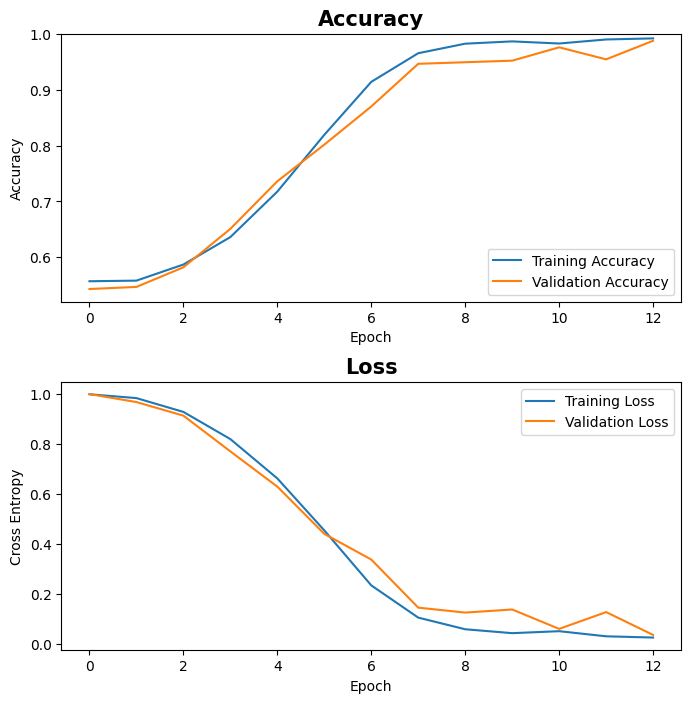

In [14]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

In [15]:
acc

[0.5571904182434082,
 0.5582997798919678,
 0.5870847105979919,
 0.6361884474754333,
 0.7175804376602173,
 0.8191159963607788,
 0.9138786792755127,
 0.9651427865028381,
 0.9821918606758118,
 0.9862789511680603,
 0.9824838042259216,
 0.989723801612854,
 0.9916505813598633]

In [16]:
val_acc

[0.5432849526405334,
 0.5470285415649414,
 0.5821244716644287,
 0.6509125232696533,
 0.7360786199569702,
 0.8015910387039185,
 0.8699110746383667,
 0.9461862444877625,
 0.9489939212799072,
 0.951801598072052,
 0.9756668210029602,
 0.9541413187980652,
 0.9873654842376709]

In [17]:
loss

[0.999497652053833,
 0.9841961860656738,
 0.9288774132728577,
 0.820085346698761,
 0.662707507610321,
 0.45475780963897705,
 0.23470504581928253,
 0.10569838434457779,
 0.0591011643409729,
 0.04345882311463356,
 0.051372647285461426,
 0.030890200287103653,
 0.02591918222606182]

In [18]:
val_loss

[1.000300645828247,
 0.9683032035827637,
 0.9139508605003357,
 0.7708954215049744,
 0.6297634243965149,
 0.44088003039360046,
 0.33801957964897156,
 0.1455739438533783,
 0.1257864534854889,
 0.13821560144424438,
 0.060546401888132095,
 0.12778344750404358,
 0.03643866255879402]

## Testing

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [20]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

67/67 [==============================] - 1s 20ms/step - loss: 0.0472 - accuracy: 0.9841


{'loss': 0.04719967022538185, 'accuracy': 0.9841417670249939}

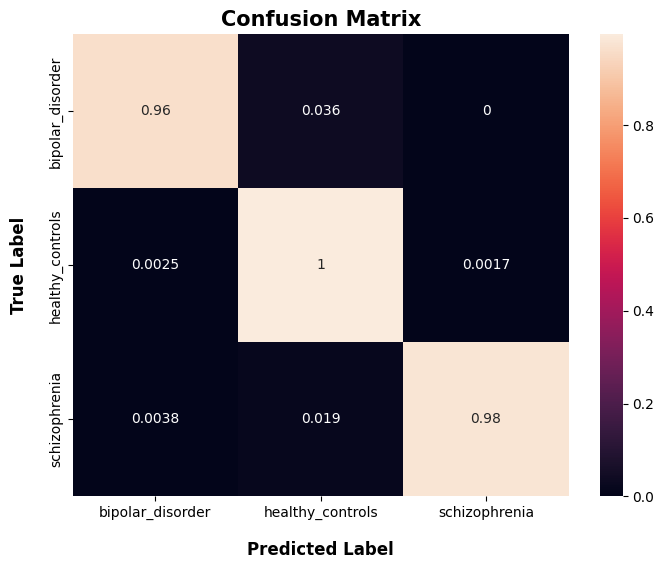

In [21]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN1_cm.png')
plt.show()

In [22]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.9841417670249939
Precision: 0.9847429429811527
Sensitivity: 0.9846082089552238
Specificity: 0.9894363127990253
